In [1]:
import re 

import xarray as xr
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import regionmask 

from src import tools

In [2]:
def quantile_error(data):
    central = np.mean(data)  # Central value (mean)
    lower = np.quantile(data, 0.025)
    upper = np.quantile(data, 0.975)
    return [central - lower, upper - central]  # Negative and positive errors


In [3]:
def get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1, resolution='c48'):
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{simulation}.MDA8_O3.april-august.{year}.nc4")
    ds_SNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{simulation_SNOx}.MDA8_O3.april-august.{year}.nc4")
    
    ds_diff = ds_SNOx-ds

    da = ds_diff[variable]*conversion_factor
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    if resolution=='c90':
        da_monthly_noland = tools.mask_ocean_c90(da_monthly)
    elif resolution=='c48':
        da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland

In [4]:
# Sensitivity Simulations
variable = "SpeciesConc_O3"
variable_string = "dO$_3$/dE$_{NOx}$"
year = 2080

simulation = "w10_pol3.7short_c48_lowCH4"
simulation_SNOx = "w10_pol3.7SNOxshort_c48_lowCH4"

polshortCH4 = get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1e9, resolution='c48')

simulation = "w10_refshort_c48_highCH4"
simulation_SNOx = "w10_refSNOxshort_c48_highCH4"

refshortCH4 = get_sensitivity_diff_values(variable, simulation, simulation_SNOx, year, conversion_factor=1e9, resolution='c48')

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [5]:
# Original simulations
def get_original_values_diff(variable, sim, sim_SNOx, conversion_factor=1, resolution='c48'):
    ds = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim}.MDA8_O3.april-august.nc4")
    ds_SNOx = xr.open_dataset(fr"/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.{sim_SNOx}.MDA8_O3.april-august.nc4")

    ds_diff = ds_SNOx-ds

    da = ds_diff[variable]*conversion_factor
    
    if "lev" in da.dims:
        da = da.isel(lev=0)
    da_monthly = da.resample(time='1M').mean(dim='time')
    da_monthly_noland = tools.mask_ocean_c48(da_monthly)
    return da_monthly_noland


In [8]:
ref = get_original_values_diff(variable, "all_ref_c48", "all_refSNOx_c48", conversion_factor=1e9, resolution='c48')
refshort = get_original_values_diff(variable, "all_refshort_c48", "all_refSNOxshort_c48", conversion_factor=1e9, resolution='c48')
polshort = get_original_values_diff(variable, "all_polshort_c48", "all_polSNOxshort_c48", conversion_factor=1e9, resolution='c48')

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:


In [9]:
print(ref.mean().values)
print(polshort.mean().values)
print(refshort.mean().values)
print(polshortCH4.mean().values)
print(refshortCH4.mean().values)

-0.6118259227223248
-0.6023617524867371
-0.5657270121065859
-0.5092615886726305
-0.7574237878282594


In [10]:
ar6_region = {
        "ENA": 5,
        "EAS": 58,
        "WCE": 17,
    }

In [11]:
def calculate_regional_mean_std(da, months, region, resolution='c48'):
    """
    Calculate the mean and standard deviation for a specific region and month.
    """
    if resolution == 'c48':
        cropped_da = tools.crop_regionmask_ar6_c48(da, region_num=ar6_region[region])
    elif resolution == 'c90':
        cropped_da = tools.crop_regionmask_ar6_c90(da, region_num=ar6_region[region])
    elif resolution == 'latlon':
        cropped_da = crop_regionmask_ar6(da, region_num=ar6_region[region])

    subset = cropped_da.sel(time=cropped_da.time.dt.month.isin(months))
    seasonal_mean = subset.resample(time='1Y').mean()

    if 'nf' in seasonal_mean.dims:
        regional_mean = seasonal_mean.mean(dim=['nf', 'Ydim', 'Xdim'])
    if 'lat' in seasonal_mean.dims:
        regional_mean = seasonal_mean.mean(dim=['lat', 'lon'])
    mean = regional_mean.mean().values
    std = quantile_error(regional_mean.values)
    return mean, std

In [12]:
def extract_means(dataset_name):
    """Returns a tuple of mean values (index=0) for each region."""
    return tuple(results[dataset_name][f"{region}"][0] for region in regions)

def extract_stds(dataset_name):
    """Returns a tuple of std values (index=1) for each region."""
    return tuple(results[dataset_name][f"{region}"][1] for region in regions)

In [13]:
datasets = {
    "ref": {
        "data": ref,
        "resolution": "c48"
    },
    "polshort": {
        "data": polshort,
        "resolution": "c48"
    },
    "refshort": {
        "data": refshort,
        "resolution": "c48"
    },
    "polshortCH4": {
        "data": polshortCH4,
        "resolution": "c48"  
    },
    "refshortCH4": {
        "data": refshortCH4,
        "resolution": "c48"   
    },
}

comparison_months = [4,5,6,7,8]
regions = ["ENA", "WCE", "EAS"]

results = {}
for ds_name, ds_info in datasets.items():
    ds_data = ds_info["data"]
    results[ds_name] = {}
    for region in regions:
        result_key = f"{region}"  # e.g. "ENA"
        results[ds_name][result_key] = calculate_regional_mean_std(
                ds_data, comparison_months, region
            )

/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-env/lib/python3.10/site-packages/xarray/core/groupby.py:346: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/home/eleroy/.conda/envs/OZCLIM-

In [14]:
def quantile_error(data):
    central = np.mean(data)  # Central value (mean)
    lower = np.quantile(data, 0.025)
    upper = np.quantile(data, 0.975)
    return [central - lower, upper - central]  # Negative and positive errors


In [15]:
ref_mean        = extract_means("ref")
polshort_mean   = extract_means("polshort")
refshort_mean   = extract_means("refshort")

polshortCH4_mean  = extract_means("polshortCH4")
refshortCH4_mean  = extract_means("refshortCH4")

ref_std        = extract_stds("ref")
polshort_std   = extract_stds("polshort")
refshort_std   = extract_stds("refshort")

In [17]:
def reshape_data(data):
    reshaped = [list(i) for i in zip(*data)]
    return reshaped

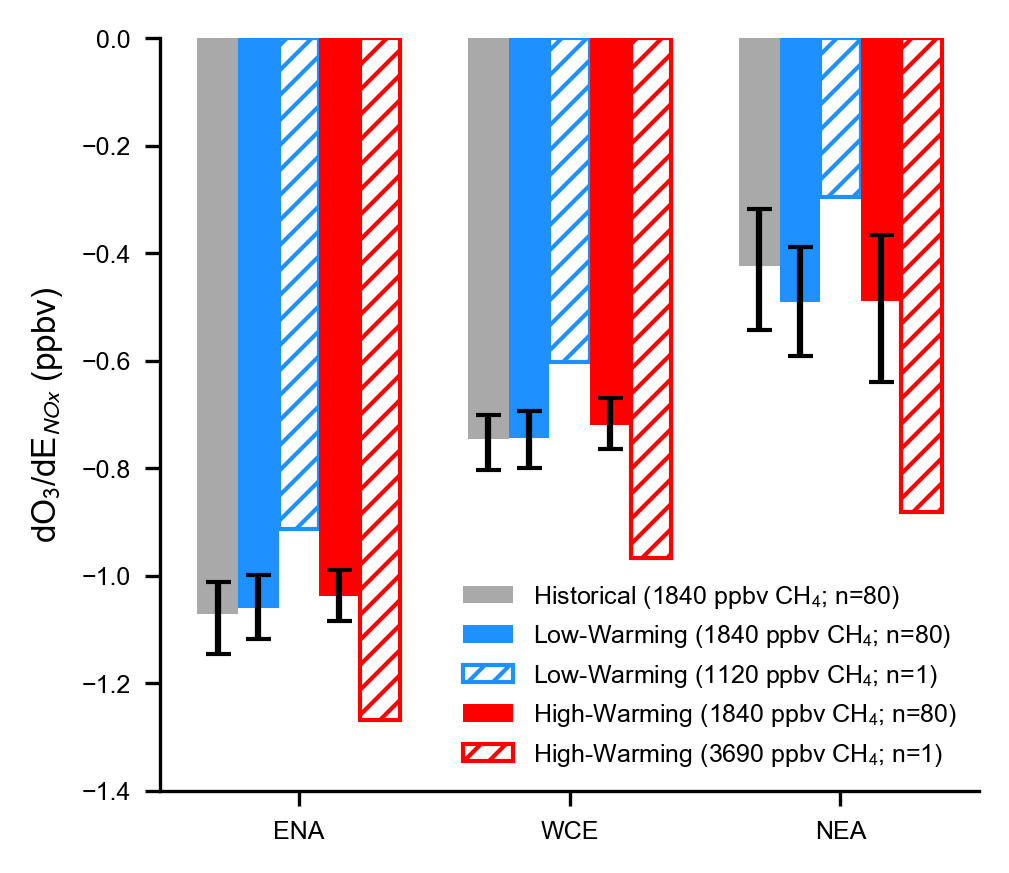

In [18]:
%matplotlib inline 

bar_width = 0.15
categories = ['ENA', 'WCE', 'NEA']
x = np.arange(len(categories))

tools.set_matplotlib_font("Arial")
mpl.rcParams.update({
    'axes.edgecolor': 'black',      
    'xtick.color': 'black',         
    'ytick.color': 'black',         
    'xtick.labelcolor': 'black',    
    'ytick.labelcolor': 'black',    
    'grid.color': 'black',          
    'axes.labelcolor': 'black',     
    'axes.titlecolor': 'black',
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 6,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6, 
    'legend.fontsize': 6,
    'figure.titlesize': 8
})


fig = plt.figure(figsize=(3.33, 2.85), dpi=300)
gs1 = GridSpec(1, 1, top=0.95, bottom=0.07, left=0.15, right=0.97, hspace=0.50, wspace=0.4)
axes = fig.add_subplot(gs1[0, 0])

axes.bar(x - 2*bar_width, ref_mean,         bar_width, yerr=reshape_data(ref_std),      capsize=3, label="Historical (1840 ppbv CH$_4$; n=80)", color="darkgray", lw=0.5)
axes.bar(x - bar_width,   polshort_mean,    bar_width, yerr=reshape_data(polshort_std), capsize=3, label="Low-Warming (1840 ppbv CH$_4$; n=80)", color="dodgerblue")
axes.bar(x,               polshortCH4_mean, bar_width, label="Low-Warming (1120 ppbv CH$_4$; n=1)", color="white", hatch='////', edgecolor="dodgerblue")
axes.bar(x + bar_width,   refshort_mean,    bar_width, yerr=reshape_data(refshort_std), capsize=3, label="High-Warming (1840 ppbv CH$_4$; n=80)", color="red")
axes.bar(x + 2*bar_width, refshortCH4_mean, bar_width, label="High-Warming (3690 ppbv CH$_4$; n=1)", color="white", hatch='////', edgecolor="red")

axes.set_ylabel(f"{variable_string} (ppbv)", fontsize=8)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(fontsize=6, frameon=False)

plt.xticks(x, categories, fontsize=6)
plt.ylim([-1.4, 0])
plt.savefig("FigS8_new.png")

In [19]:
# METHANE LBCs

pol = xr.open_dataarray("/net/fs11/d1/seastham/CEDS_EPPA_Emissions/GHGs/Processed/CH4_windDrnd10_CS3p0_Fae-0p70_Kz0p05_pol3.7_1999-2101.nc4")
pol_2014 = pol.isel(time=pol.time.dt.year.isin([2014]))
pol_2100 = pol.isel(time=pol.time.dt.year.isin([2080]))
mean_2014_float = float(pol_2014.mean().values)
mean_2100_float = float(pol_2100.mean().values)

rounded_2014 = float(f"{mean_2014_float:.3g}")
rounded_2100 = float(f"{mean_2100_float:.3g}")

print(rounded_2014, rounded_2100)

ref = xr.open_dataarray("/net/fs11/d1/seastham/CEDS_EPPA_Emissions/GHGs/Processed/CH4_windDrnd13_CS3p0_Fae-0p70_Kz0p05_ref_1999-2101.nc4")
ref_2014 = ref.isel(time=ref.time.dt.year.isin([2014]))
ref_2080 = ref.isel(time=ref.time.dt.year.isin([2080]))
mean_2014_float = float(ref_2014.mean().values)
mean_2080_float = float(ref_2080.mean().values)

rounded_2014 = float(f"{mean_2014_float:.3g}")
rounded_2080 = float(f"{mean_2080_float:.3g}")

print(rounded_2014, rounded_2080)

1840.0 1120.0
1840.0 3690.0
